In [1]:
library(dplyr)
library(ggplot2)

data1 = read.table('MZ_out_igblast_db-pass.tab', header = 1, stringsAsFactors = FALSE, sep = '\t')

data1$lane = 1

data =rbind(data1)

data = data  %>% rename(CLUSTER_ID = SEQUENCE_ID)

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
data$BC_UMI = gsub(x = data$CLUSTER_ID, pattern = '[^A-Z.-]', replacement = '')
data$BC = substring(data$BC_UMI, 1, 12)
data$UMI = substring(data$BC_UMI, 13, 20)
data$CLUSTER = gsub(x = data$CLUSTER_ID, pattern = '[^0-9.-]', replacement = '')                  
head(data %>% select(CLUSTER_ID, BC_UMI, BC, UMI, CLUSTER))

,CLUSTER_ID,BC_UMI,BC,UMI,CLUSTER
,<chr>,<chr>,<chr>,<chr>,<chr>
1,2NCATCTTCACAAGTGGTCTG,NCATCTTCACAAGTGGTCTG,NCATCTTCACAA,GTGGTCTG,2
2,2NCCTTCAGGAACAATACCCC,NCCTTCAGGAACAATACCCC,NCCTTCAGGAAC,AATACCCC,2
3,2NACGTACATTATTGCGAATG,NACGTACATTATTGCGAATG,NACGTACATTAT,TGCGAATG,2
4,2NGCGCCCCGCGGATCTCGTT,NGCGCCCCGCGGATCTCGTT,NGCGCCCCGCGG,ATCTCGTT,2
5,1NACGTACATTATTGCGAATG,NACGTACATTATTGCGAATG,NACGTACATTAT,TGCGAATG,1
6,1NTCTTAAGACTTACCTGATA,NTCTTAAGACTTACCTGATA,NTCTTAAGACTT,ACCTGATA,1


In [3]:
summary_frame = data %>% group_by(lane, BC_UMI) %>% summarize(nReads = sum(CONSCOUNT))
head(summary_frame)

`summarise()` has grouped output by 'lane'. You can override using the `.groups` argument.


lane,BC_UMI,nReads
<dbl>,<chr>,<int>
1,AAAAAAAAAAAAAAAAAAAA,94
1,AAAAAAAAAACAACCAAAAT,4
1,AAAAAAAAAACGAGCACACT,3
1,AAAAAAAAAAGACTAAACAA,3
1,AAAAAAAAACATCGATCCGG,4
1,AAAAAAAAACATCGTTCCGG,3


In [4]:
summary_frame$id = paste0(summary_frame$lane, summary_frame$BC_UMI)
data$id = paste0(data$lane, data$BC_UMI)


In [5]:
data = as.data.frame(data)
data$nUMI_reads = summary_frame[match(data$id, summary_frame$id), 'nReads']$nReads

In [6]:
data = data %>% mutate(UMI_FRAC = CONSCOUNT/nUMI_reads) 
summary(data$UMI_FRAC)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000039 0.0021802 0.0449827 0.3789954 1.0000000 1.0000000 

In [7]:
data$AMBIG = FALSE
data$AMBIG[grep(pattern = 'N', x = data$JUNCTION)] = TRUE
table(data$AMBIG)



  FALSE    TRUE 
3070893 1326144 

Loading required package: cowplot


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: Matrix



[1] 56149    61


        0         1         2         3 
0.2281671 0.1025198 0.4008745 0.2684386 

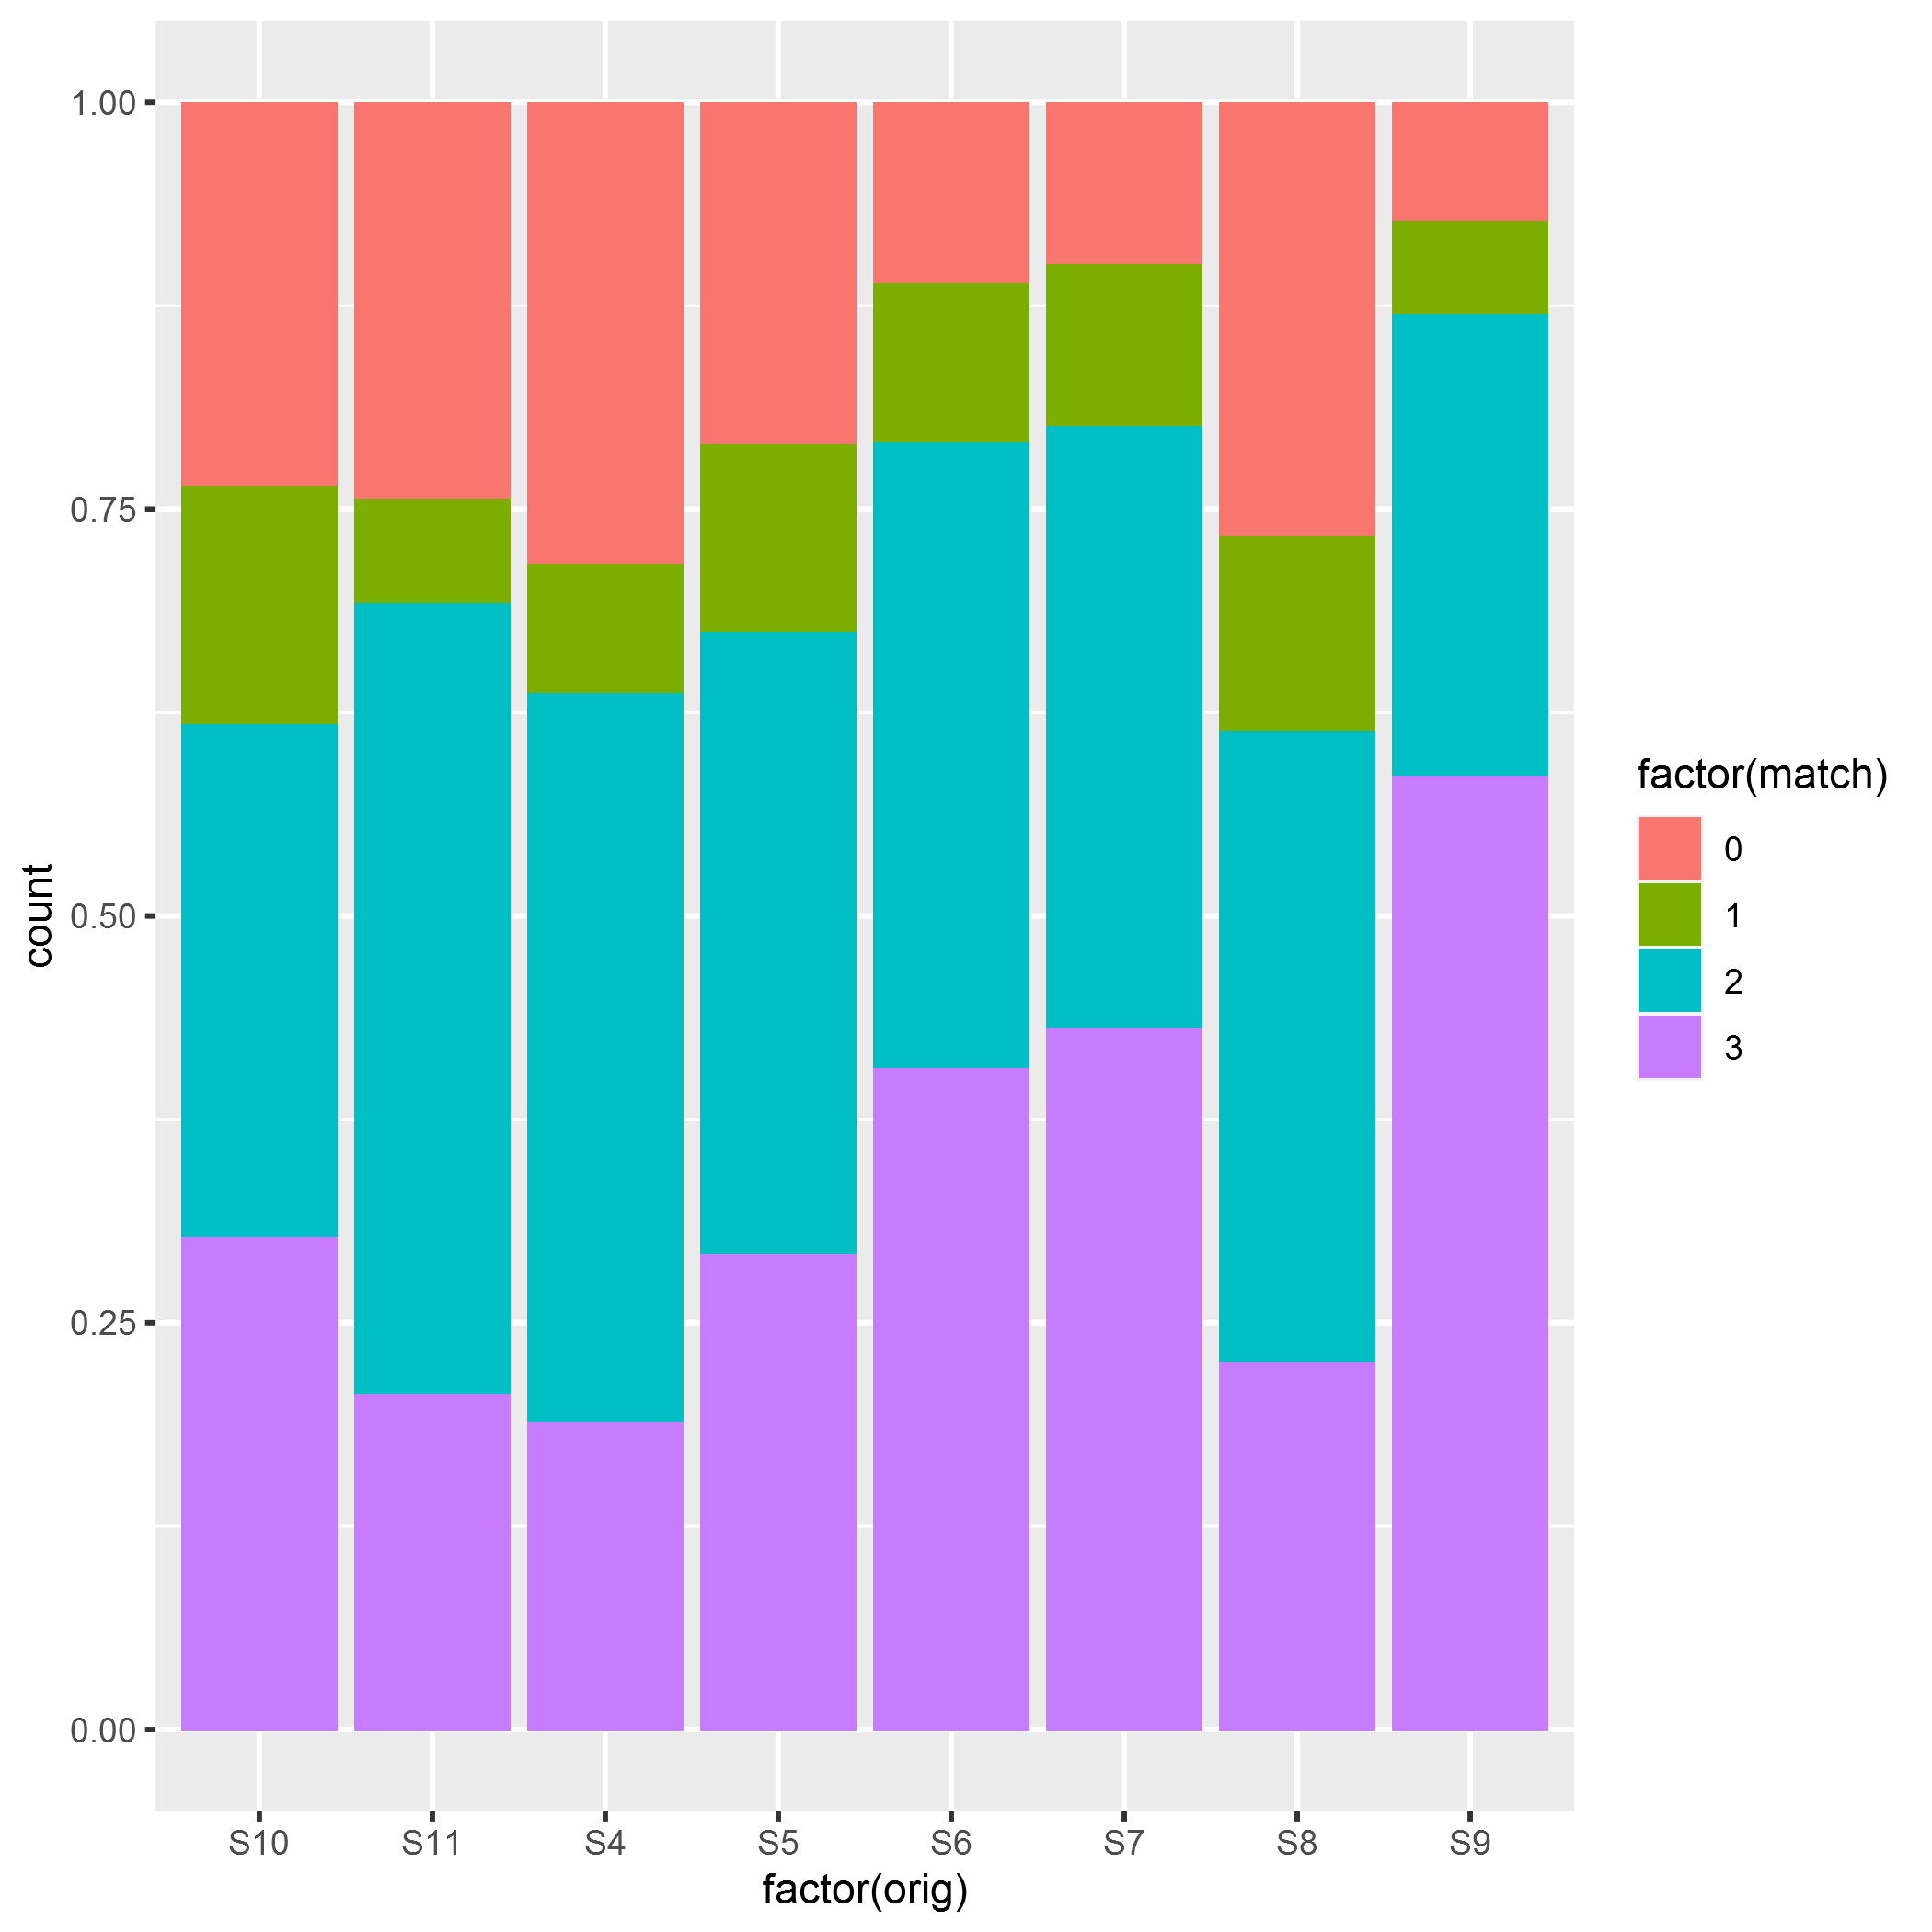

In [8]:
seurat = readRDS('../ln_seurat.RDS')
#seurat2 = readRDS('../tissue_seurat.RDS')
library(Seurat)
#seurat = MergeSeurat(seurat, seurat2)
options(repr.plot.res = 300)
matches = data %>% ungroup() %>% filter(BC %in% seurat@meta.data$bc, CONSCOUNT > 10, !AMBIG, UMI_FRAC > 0.9)
dim(matches)
metadata = seurat@meta.data

metadata$matchedB = as.numeric(metadata$bc %in% matches$BC[matches$LOCUS == 'TRB'])
metadata$matchedA = as.numeric(metadata$bc %in% matches$BC[matches$LOCUS == 'TRA'])
metadata$match = 2*metadata$matchedB + 1*metadata$matchedA
table(metadata$match)/length(metadata$match)
ggplot(metadata %>% filter(n_genes > 300), aes(x = factor(orig), fill = factor(match))) + geom_bar(position = 'fill') 

In [9]:
library(alakazam)

matches$CDR3 = translateDNA(matches$JUNCTION)
matches$TopVregion = matches$V_CALL
matches$TopJregion = matches$J_CALL
matches$nReads = matches$CONSCOUNT
matches$CDR3nuc =matches$JUNCTION
head(matches$CDR3)

# fix TRBV30-1
#matches$CDR3[matches$V_CALL == 'TRBV30*01'] = gsub(x = matches$CDR3[matches$V_CALL == 'TRBV30*01'],pattern = 'YIC', replacement = 'C')
#matches$CDR3[matches$V_CALL == 'TRBV30*01'] = gsub(x = matches$CDR3[matches$V_CALL == 'TRBV30*01'],pattern = 'YLC', replacement = 'C')

# fix TRBJ2-6
#matches$CDR3[grep(matches$J_CALL, pattern = 'TRBJ2-6', fixed = TRUE)] = gsub(x = matches$CDR3[grep(matches$J_CALL, pattern = 'TRBJ2-6*01', fixed = TRUE)] ,pattern = 'GANVLT', replacement = 'GANVLTF')


As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.



[1] "CASSLRDWGYEQYF"  "CSSRERNYAEQFF"   NA                "CALTPRNNYAQGLTF"
[5] "CAASAGSWQLIF"    "CASSGVSNERLFF"

In [10]:
metadata = seurat@meta.data
metadata$TRB_CDR3 = NA
metadata$TRBV = NA


TCR_df <- matches %>% filter(BC %in% metadata$bc,CONSCOUNT > 5, !AMBIG, UMI_FRAC > 0.95)


# Clean & Format ----------------------------------------------------------
#Then let's clean cast some variable into usable formats
TCR_df <- TCR_df %>% mutate(TopVregion = factor(TopVregion), TopJregion = factor(TopJregion))

#Clean the TCR from umi that gave no CDR3. then orders first by BC, then by nReads within each BC
TCR_df_cleaned <- TCR_df %>% filter(!is.na(CDR3)) %>% arrange(BC, desc(nReads))

#I think there are still several things to do. One is to quantify how many UMI each CDR3 has,
#and then sort the files by UMI, then by reads.

#here we create a second df that records (BC,CDR3) combination and their respective UMI_count
#The unique argument is key here. It prevent double countings
TCR_df_cleaned_UMI_count <- TCR_df_cleaned %>% count(BC, CDR3) %>% rename(UMI_count = n)

#then we make merge the two, grouped by Barcode and CDR3
TCR_df_cleaned<-left_join(TCR_df_cleaned, TCR_df_cleaned_UMI_count, by = c('BC','CDR3')) #%>% arrange(BC, desc(UMI_count),desc(nReads))

#re-order a little bit for readability
TCR_df_cleaned<- TCR_df_cleaned %>% select(BC,UMI,UMI_count,nReads,everything())

#then re-order the rows again just to make sure the top UMI_count/nReads results are at the top of each 
#cell barcode group.
TCR_df_cleaned<- TCR_df_cleaned[with(TCR_df_cleaned,order(BC,UMI_count,nReads,decreasing=TRUE)),]

#Separate df into alpha and beta chain into two dataframes

TRA_df <- TCR_df_cleaned %>% filter(LOCUS == 'TRA')
TRB_df <- TCR_df_cleaned %>% filter(LOCUS == 'TRB') %>% filter(FUNCTIONAL)


#Then we should generate masks of matching barcodes. We would probably have to do two masks
#Note: these values are just masks that apply to (not BCseq, but) TRA/TRB_df list of values. i.e. it gives
#indices of where in the TRA/TRB_df, do you find the correspoding rank position of the same cell (i.e. first
#position is first cell in the BCSeqlist.)
#BCSeq has to be the total list of barcodes for all of the cells in the Seurat object

BCSeq = metadata$bc
is.na(match(BCSeq, TRA_df$BC)) == 0 -> TRA_BC 
is.na(match(BCSeq, TRB_df$BC)) == 0 -> TRB_BC 
TRA_BC & TRB_BC ->TRAB_BC

#is.na(match(BCSeq, TCR_df$BC)) == 0 -> TCR_BC
#is.na(match(BCSeq, TCR_df_cleaned$BC)) == 0 -> TCR_cleaned_BC

#here we construct the mapping necessary to look at mapping statistics 
metadata$TCR_Recovery <- "No Recovery"
metadata$TCR_Recovery[c(TRB_BC)] <- "TRB only"
metadata$TCR_Recovery[c(TRA_BC)] <- "TRA only"
metadata$TCR_Recovery[c(TRAB_BC)] <- "TRA and TRB"

metadata$TRB_CDR3 <- "No Recovery"
metadata$TRB_CDR3 <- TRB_df$CDR3[match(BCSeq,TRB_df$BC)]
metadata$TRBV <- TRB_df$TopVregion[match(BCSeq,TRB_df$BC)]
metadata$TRBJ<- TRB_df$TopJregion[match(BCSeq,TRB_df$BC)]
metadata$TRB_nuc = TRB_df$CDR3nuc[match(BCSeq,TRB_df$BC)]


#checked and the data seems to make sense
#The problem here is that this only gives us one TRA, but we should look at multiple. 

#First we get rid of the duplicates of the TRA, because in a lot of importing of data, we are importing 
#duplicated data since the same sample could be sequenced multiple times, etc. 

TRA_df %>% distinct(BC,CDR3,TopVregion, .keep_all = TRUE) -> TRA_uniq_df

match(BCSeq,TRA_uniq_df$BC) -> TRA1_Match

metadata$TRA_CDR3 <- "No Recovery"
metadata$TRA_CDR3 <- TRA_uniq_df$CDR3[TRA1_Match]
metadata$TRAV <- TRA_uniq_df$TopVregion[TRA1_Match]
metadata$TRAJ<- TRA_uniq_df$TopJregion[TRA1_Match]
metadata$TRA_nuc = TRA_uniq_df$CDR3nuc[TRA1_Match]

#then we remove the rows that we just assigned 
TRA1_Match_filter <- TRA1_Match[!is.na(TRA1_Match)]
TRA2_uniq_df <- TRA_uniq_df[-TRA1_Match_filter, ]

match(BCSeq,TRA2_uniq_df$BC) -> TRA2_Match

metadata$TRA.2_CDR3 <- NA
metadata$TRA.2_CDR3 <- TRA2_uniq_df$CDR3[TRA2_Match]
metadata$TRAV.2 <- TRA2_uniq_df$TopVregion[TRA2_Match]
metadata$TRAJ.2<- TRA2_uniq_df$TopJregion[TRA2_Match]
metadata$TRA2_nuc = TRA2_uniq_df$CDR3nuc[TRA2_Match]


In [11]:
library(stringr)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*01', replacement = '', fixed = TRUE)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*02', replacement = '', fixed = TRUE)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*03', replacement = '', fixed = TRUE)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*04', replacement = '', fixed = TRUE)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*05', replacement = '', fixed = TRUE)
metadata$TRBJ = gsub(metadata$TRBJ, pattern = '*01', replacement = '', fixed = TRUE)
metadata$TRBJ = gsub(metadata$TRBJ, pattern = '*02', replacement = '', fixed = TRUE)
metadata$TRBV = gsub(metadata$TRBV, pattern = '*07', replacement = '', fixed = TRUE)

metadata$TRBV = sapply(metadata$TRBV, function(x) str_split(x, ',')[[1]][1])
metadata$TRBJ = sapply(metadata$TRBJ, function(x) str_split(x, ',')[[1]][1])

table(metadata$TRBV)
table(metadata$TRBJ)


   TRBV1 TRBV12-1 TRBV12-2 TRBV13-1 TRBV13-2 TRBV13-3   TRBV14   TRBV15 
     732     1195      558      538     1254      736      131      317 
  TRBV16   TRBV17   TRBV19    TRBV2   TRBV20   TRBV23   TRBV24   TRBV26 
     701      127      340      490      362       72        2      444 
  TRBV29    TRBV3   TRBV30   TRBV31    TRBV4  TRBV4-1    TRBV5    TRBV6 
     238      714       48      640      188        1      693        1 
   TRBV8 
       1 


TRBJ1-1 TRBJ1-2 TRBJ1-3 TRBJ1-4 TRBJ1-5 TRBJ1-6 TRBJ2-1 TRBJ2-2 TRBJ2-3 TRBJ2-4 
   1040     500     620     713     261     415    1081     524     788    1090 
TRBJ2-5 TRBJ2-7 
   1379    2112 

In [12]:
saveRDS(metadata, 'tcrmeta.RDS')